In [2]:
import matplotlib.pyplot as plt
from freegs.machine import Coil, Solenoid, Machine, Wall
from freegs import optimise as opt
from freegs.jtor import ConstrainBetapIp
from freegs.equilibrium import Equilibrium
from freegs.control import constrain
from freegs import solve
from Geometry import * 

In [3]:
# Global configurations

# Plasma Parameters
Ip = 10e3 # A
B0 = 0.125
poloidal_plasma_beta = 0.05
xpoints = [(0.3, -0.24), (0.3, 0.24)]  # (R,Z) locations of X-points
isoflux = [(0.3, -0.24, 0.3, 0.24)] # (R1,Z1, R2,Z2) pairs


# Central Solenoid
cs_turns = 104 # Turns

# Dimension of coils
wc = 0.05
hc = 0.03

# Position of coils in (R, Z) pairs for coils located at (R, Z) and (R, -Z)
mirrored_PF_coils_positions = [
    (0.22, 0.3),
    (0.40, 0.27),
    (0.52, 0.15)
]

# Simulation Domain
Rmax = 0.7
Rmin = 0.01
Zmax = 0.6
Zmin = -0.6
n = 129           # Number of grid points (must always be in the for

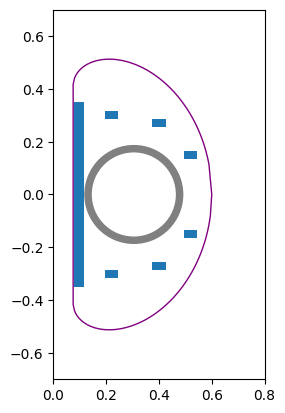

In [4]:
g = Geometry()

for index, (r, z) in enumerate(mirrored_PF_coils_positions):
    g.create_coil(f'PF{index}_U',r, z, wc, hc)
    g.create_coil(f'PF{index}_L',r, -z, wc, hc)

g.plot()

In [5]:
coils = [(name, Coil(prop['r0'], prop['z0'], control=(name != 'CS'))) for name, prop in g.geom['coils'].items()]
RWall, ZWall = list(zip(*g.geom['vv'][0])) 
walls = Wall(RWall, ZWall)

tokamak = Machine(coils, walls)
for coil_name, _ in tokamak.coils:
    if coil_name != 'CS':
        tokamak[coil_name].area = wc * hc
        
eq = Equilibrium(tokamak=tokamak,
                 Rmin=Rmin, Rmax=Rmax,  # Radial domain
                 Zmin=Zmin, Zmax=Zmax,  # Height range
                 nx=n, ny=n  # Number of grid points
                 )

profiles = ConstrainBetapIp(eq,
                            poloidal_plasma_beta,  # Plasma poloidal beta
                            Ip,  # Plasma current [Amps]
                            g.vv_major_radius * B0)  # Vacuum f=R*Bt

constraints = constrain(xpoints=xpoints, isoflux=isoflux)

In [6]:
solve(eq,
      profiles,
      constraints,
      check_limited=True,
      limit_it = 0,
      )

In [7]:
# Print Results
print(
    'Plasma Properties:\n'
    f'\t Plasma Current     {eq.plasmaCurrent():8.2f}\n'
    f'\t Plasma Elongation  {eq.elongation():8.2f}\n'
    f'\t Plasma Triangular  {eq.triangularity():8.2f}\n'
    f'\t Plasma Triangular  {eq.triangularity():8.2f}\n'
    f'\t Plasma Volume      {eq.plasmaVolume():8.2f}\n'
)

print('Current Profile')
for name, coil in eq.tokamak.coils:
    print(f'\t {name}: Current: {coil.current:8.2f} A')

Plasma Properties:
	 Plasma Current     10000.00
	 Plasma Elongation      1.42
	 Plasma Triangular      0.11
	 Plasma Triangular      0.11
	 Plasma Volume          0.11

Current Profile
	 CS: Current:     0.00 A
	 PF0_U: Current:  4015.96 A
	 PF0_L: Current:  4015.96 A
	 PF1_U: Current:  1287.88 A
	 PF1_L: Current:  1287.90 A
	 PF2_U: Current: -3685.56 A
	 PF2_L: Current: -3685.59 A


/home/roy/.local/lib/python3.10/site-packages/freegs/critical.py:415: UserWarning: Theta grid too close to X-point, shifting by half-step
  warn("Theta grid too close to X-point, shifting by half-step")
/home/roy/.local/lib/python3.10/site-packages/freegs/jtor.py:219: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  shapeintegral, _ = quad(


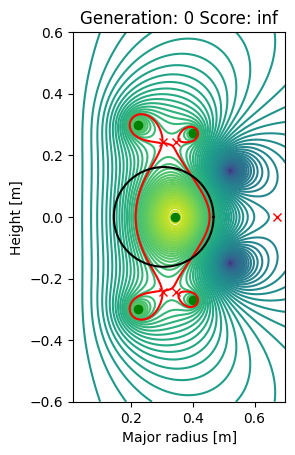

/home/roy/.local/lib/python3.10/site-packages/freegs/critical.py:415: UserWarning: Theta grid too close to X-point, shifting by half-step
  warn("Theta grid too close to X-point, shifting by half-step")
/home/roy/.local/lib/python3.10/site-packages/freegs/jtor.py:219: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  shapeintegral, _ = quad(
/home/roy/.local/lib/python3.10/site-packages/freegs/critical.py:415: UserWarning: Theta grid too close to X-point, shifting by half-step
  warn("Theta grid too close to X-point, shifting by half-step")
/home/roy/.local/lib/python3.10/site-packages/freegs/critical.py:415: UserWarning: Theta grid too close to X-point, shifting by half-step
  warn("Theta grid too close to X-point, shifting by half-step")
/home/roy/.local/lib/python3.10/site-packages/freegs/jtor.py:219: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  shapeintegral, _ =

In [10]:
best_eq = opt.optimise(
    eq,
    [
        opt.CoilRadius('PF0_U', minimum=0.1, maximum=0.4),
        opt.CoilRadius('PF0_L', minimum=0.1, maximum=0.4),
        opt.CoilRadius('PF1_U', minimum=0.2, maximum=0.5),
        opt.CoilRadius('PF1_L', minimum=0.2, maximum=0.55),
        opt.CoilRadius('PF2_U', minimum=0.45, maximum=0.55),
        opt.CoilRadius('PF2_L', minimum=0.45, maximum=0.55),
    ],
    opt.weighted_sum(opt.max_abs_coil_current, opt.no_wall_intersection),
    N=10,
    maxgen=20,
    monitor=opt.PlotMonitor()
)